In [1]:
library(data.table)
library(tidyverse)
library(fuzzyjoin)
library(broom)
library(patchwork)
library(ggpubr)
library(ape)
library(tidytree)
library(ggtree)
library(plotly)
library(MASS)
library(Matrix)
library(scales)
library(ggrepel)
theme_set(theme_pubr(base_size=8, legend="bottom"))
source("../R/helper.R")
options(repr.plot.res = 150)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()

Warning message:
"package 'fuzzyjoin' was built under R version 4.0.3"

Attaching package: 'ape'


The following object is masked from 'package:ggpubr':

    rotate



Attaching package: 'tidytree'


The following object is masked from 'package:stats':

    filter


Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.0.0  For help: https://yulab-smu.github.io/treedata-boo

In [2]:
args = commandArgs(trailingOnly = TRUE)

In [3]:
#args = strsplit("../../output/joined_stats/sup-rand-id_UWIHTH76U466661H5T_rep_0_win-size_1000000_sample-size_10.tsv ../../output/sims_results/sup-rand-id_UWIHTH76U466661H5T_rep_0_win-size_1000000_sample-size_10/ figs/ 0.4", " ")


In [4]:
# Input parameters

## paths
if (length(args) < 4) {
    inpath = '../../output/joined_stats/sup-rand-id_O814WK8MN3UOF27JIR_rep_0_win-size_1000000_sample-size_10.tsv'
    #inpath = '../../output/greatapes-diversity-data/all_pidxy_win-size_1000000_merged-mask_True.tsv'
    outpath = '../../output/'
    figpath = 'figs/'
    prop = 0.4
} else {
    print(args)
    inpath = args[1]
    outpath = args[2]
    figpath = args[3]
    prop = as.numeric(args[4])

}
filemeta = meta_from_fname(inpath, prop=prop)

In [5]:
# reading annotation tracks
rec_map = fread('../../hg18/decode_rec_map.tsv')
rec_map = rec_map[,c(1,2,3,5)]
colnames(rec_map) = c("chr", "start", "end", "mean_rate")

rep_timing = fread('../../hg18/replication_timing.tsv')
rep_timing$chr = paste0("chr", rep_timing$chr)

exons = fread('../../hg18/annotations/exon.bed.merged', col.names = c("chr", "start", "end"))

phastcons = fread('../../hg18/annotations/phastConsElements44wayPrimates.bed.merged', col.names = c("chr", "start", "end"))

In [6]:
# reading metadata
edges = fread('../../data/meta/edges_meta.tsv', sep="\t", header=T, fill=T)
edges[edges$edge == 'western_gorila']$edge = 'western_gorilla'
edges$edge = str_replace(edges$edge, "_", "-")
edges$parent = str_replace(edges$parent, "_", "-")
root = edges[edges$parent == "",]$edge
edges[edges$edge==root]$gens = edges[edges$edge==root]$N

In [7]:
# getting a newick tree from metadata table and computing distances/MRCAs
treestr = build_nwk(root, as.data.frame(edges[,c("edge", "parent", "gens")]))
tree = read.tree(text=treestr)
write.tree(tree, file="../../output/ga.nwk")
treetbl = as_tibble(tree)
dist_mat = data.frame(dist.nodes(tree))
colnames(dist_mat) = treetbl$label
rownames(dist_mat) = treetbl$label
mrca_mat = data.frame(mrca(tree, full=TRUE))
for (i in 1:nrow(mrca_mat)) {
    for (j in 1:ncol(mrca_mat)) {
        mrca_mat[i,j] = treetbl[treetbl$node==mrca_mat[i,j],]$label
    }
}
colnames(mrca_mat) = treetbl$label
rownames(mrca_mat) = treetbl$label
treetbl=dplyr::left_join(x = treetbl, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("label"="edge"))

In [8]:
# reading stats computed from VCF/treeseq
pidxy = fread(inpath)

# some fixes (that are only necessary for the real data side of things)
# changing from 1-based to 0-based in case of the data side
pidxy$start = pidxy$start-as.integer(filemeta$is_ga_data)
pidxy$spp1 = str_replace(pidxy$spp1, "_", "-")
pidxy$spp2 = str_replace(pidxy$spp2, "_", "-")
pidxy[pidxy$spp1=='homo',]$spp1 = "humans"
pidxy[pidxy$spp2=='homo',]$spp2 = "humans"
pidxy[pidxy$spp1=='western-gorila',]$spp1 = "western-gorilla"
pidxy[pidxy$spp2=='western-gorila',]$spp2 = "western-gorilla"
# masking windows with low accessibility
## TODO: instead of removing the windows, just set the values to NA
pidxy = pidxy[pidxy$n_acc_bases > filemeta$win_size*filemeta$prop,]

In [9]:
#pidxy = fread(inpath)
head(pidxy)

value       stat spp1          spp2          chr  start   end     n_acc_bases
1 0.002372976 pi   central-chimp central-chimp chr1 2000000 3000000 455783     
2 0.002249262 pi   central-chimp central-chimp chr1 3000000 4000000 570312     
3 0.002725537 pi   central-chimp central-chimp chr1 4000000 5000000 794579     
4 0.002376450 pi   central-chimp central-chimp chr1 5000000 6000000 553139     
5 0.001678865 pi   central-chimp central-chimp chr1 6000000 7000000 663579     
6 0.001894759 pi   central-chimp central-chimp chr1 7000000 8000000 769560     
  n_snps
1 12411 
2 15847 
3 21968 
4 14346 
5 14005 
6 17301

In [10]:
# quick summary
pidxy[pidxy$stat=="pi",] %>% 
    group_by(spp1, spp2, stat) %>%
    summarise(m = weighted.mean(value, w=n_acc_bases, na.rm=T))

`summarise()` has grouped output by 'spp1', 'spp2'. You can override using the `.groups` argument.



spp1               spp2               stat m           
1  bonobo             bonobo             pi   0.0007378263
2  bornean-orangutan  bornean-orangutan  pi   0.0015943974
3  central-chimp      central-chimp      pi   0.0017127172
4  eastern-chimp      eastern-chimp      pi   0.0015091176
5  eastern-gorilla    eastern-gorilla    pi   0.0007005082
6  humans             humans             pi   0.0009139375
7  nigerian-chimp     nigerian-chimp     pi   0.0013294575
8  sumatran-orangutan sumatran-orangutan pi   0.0022103122
9  western-chimp      western-chimp      pi   0.0007217959
10 western-gorilla    western-gorilla    pi   0.0016701201

In [11]:
# adding mrca and tmrca labels
qual_stats = c(setdiff(unique(pidxy$stat), c("pi", "dxy")),"n_acc_bases")
pidxy$combo = paste(pidxy$spp1, pidxy$spp2, sep="_")
pidxy[stat == "pi"]$combo = pidxy[stat == "pi"]$spp1
pidxy[stat %in% qual_stats]$combo = pidxy[stat %in% qual_stats]$spp1
tmp = unique(pidxy[,c("spp1","spp2","combo")])
dt=apply(tmp, 1, function(x) dist_mat[x[1],x[2]])
mrca=apply(tmp, 1, function(x) mrca_mat[x[1],x[2]])
tmp = cbind(tmp, dt)
tmp = cbind(tmp, mrca)

In [12]:
setkey(tmp, mrca)
setkey(edges, edge)
tmp = tmp[edges[,c("edge", "ancestral_coding", "N")],]
pidxy=tmp[pidxy, on=.(spp1,spp2)]
combo_levels = tmp$combo[order(tmp$combo!=tmp$mrca, tmp$dt, tmp$ancestral_coding)]
u = tmp %>%
  distinct(mrca, ancestral_coding, dt) %>%
  group_by(mrca, ancestral_coding) %>%
  summarize(meandt = mean(dt))
mrca_levels = u$mrca[order(u$meandt, u$ancestral_coding)]
pidxy$combo = factor(pidxy$combo, levels = combo_levels, labels=str_replace(combo_levels, "_", " "))
# levels ordered by within vs between spp comparison, tmrca, and ancestral coding (tree order)
pidxy$mrca = factor(pidxy$mrca, levels=mrca_levels)

`summarise()` has grouped output by 'mrca'. You can override using the `.groups` argument.



In [13]:
options(repr.plot.width=15, repr.plot.height=20)
# making a plot of pi against quality measures
if(filemeta$is_ga_data) {
    p_piqual = pidxy %>% 
    filter(stat != "dxy") %>%
    pivot_wider(names_from = stat, values_from = value) %>%
    pivot_longer(cols=all_of(qual_stats), names_to = "stat", values_to="value") %>%
    ggplot(aes(y=pi, x=value)) + 
        stat_cor(method="spearman", aes(label = ..rr.label..)) +
        geom_hex() +
        facet_wrap(vars(combo, stat), ncol=6, scales="free")

    p_piqual
    ggsave(paste0(outpath, figpath, "pi-by-qualmetrics_", filemeta$desc, ".pdf"), 
       width=6.5, height=10, scale=2, units="in", limitsize=FALSE)

    # from here we only care about pi and dxy, so dropping other stats
    pidxy = pidxy[!pidxy$stat %in% qual_stats,] 
}

In [14]:
# joining with rec map
pidxy = as.data.table(genome_left_join(pidxy, rec_map, by = c("chr","start", "end"), minoverlap=2)) # minoverlap bc end is not inclusive
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy=pidxy[, .(mean_rec = weighted.mean(mean_rate, percent)), by=setdiff(colnames(pidxy), c("rate", "start.y", "end.y", "chr", "percent", "mean_rate"))]
setnames(pidxy, c("chr.x","start.x", "end.x"), c("chr","start","end"))
pidxy[,c("chr.y") := NULL]

In [15]:
# joining with exons
pidxy = as.data.table(genome_left_join(pidxy, exons, by = c("chr", "start", "end"), minoverlap=2))
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy[is.na(pidxy$percent)]$percent=0
pidxy=pidxy[, .(ex_overlap = sum(percent)), by=setdiff(colnames(pidxy), c("start.y", "chr", "end.y", "percent"))]
setnames(pidxy, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pidxy[, ex_overlap := 100*ex_overlap]
pidxy[,c("chr.y") := NULL]
pidxy[is.na(pidxy$ex_overlap), ]$ex_overlap = 0

In [16]:
# joining with phastcons
pidxy = as.data.table(genome_left_join(pidxy, phastcons, by = c("chr", "start", "end"), minoverlap=2))
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy[is.na(pidxy$percent)]$percent=0
pidxy=pidxy[, .(pcons_overlap = sum(percent)), by=setdiff(colnames(pidxy), c("start.y", "chr", "end.y", "percent"))]
setnames(pidxy, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pidxy[, pcons_overlap := 100*pcons_overlap]
pidxy[,c("chr.y") := NULL]

In [17]:
head(pidxy)

spp1          spp2          combo         dt mrca          ancestral_coding
1 central-chimp central-chimp central-chimp 0  central-chimp 2               
2 central-chimp central-chimp central-chimp 0  central-chimp 2               
3 central-chimp central-chimp central-chimp 0  central-chimp 2               
4 central-chimp central-chimp central-chimp 0  central-chimp 2               
5 central-chimp central-chimp central-chimp 0  central-chimp 2               
6 central-chimp central-chimp central-chimp 0  central-chimp 2               
  N     value       stat chr  start   end     n_acc_bases n_snps i.combo      
1 30000 0.002372976 pi   chr1 2000000 3000000 455783      12411  central-chimp
2 30000 0.002249262 pi   chr1 3000000 4000000 570312      15847  central-chimp
3 30000 0.002725537 pi   chr1 4000000 5000000 794579      21968  central-chimp
4 30000 0.002376450 pi   chr1 5000000 6000000 553139      14346  central-chimp
5 30000 0.001678865 pi   chr1 6000000 7000000 663579      14005  central-chimp
6 30000 0.001894759 pi   chr1 7000000 8000000 769560      17301  central-chimp
  mean_rec ex_overlap pcons_overlap
1 1.11892  5.3294     2.1741       
2 1.96161  5.8978     2.9649       
3 2.63621  0.7937     1.8236       
4 2.15512  1.0059     1.7304       
5 1.99907  7.8704     6.4212       
6 1.69133  2.7493     5.5098

In [18]:
# correlations between rec,ex and pcons, and pidxy
options(warn=-1)
rec_percentile=0.7
pidxy$high_rec = pidxy$mean_rec > quantile(pidxy$mean_rec, rec_percentile, na.rm = T)
pidxy[is.na(pidxy$high_rec),]$high_rec = FALSE
recbin_labels = c("TRUE" = "High recombination (top 10%)",
                 "FALSE" = "Low recombination (bottom 90%)")

In [19]:
options(warn=-1)

cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca,high_rec) %>% 
    do(tidy(cor.test(.$value, .$mean_rec, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))

cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca, high_rec) %>% 
    do(tidy(cor.test(.$value, .$ex_overlap, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))

cor_pcons = pidxy %>%
    group_by(spp1,spp2, dt, mrca, high_rec) %>% 
    do(tidy(cor.test(.$value, .$pcons_overlap, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))
options(warn=-0)
write.table(cor_rec, paste0(outpath,"cor-pidxy-rec-rate-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_ex, paste0(outpath,"cor-pidxy-exon-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_pcons, paste0(outpath,"cor-pidxy-pcons-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

In [20]:
options(repr.plot.width=12, repr.plot.height=8)

col19palette = c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527","#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")

p_corex_byrec = ggplot(cor_ex, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
            facet_grid(vars(high_rec), labeller = as_labeller(recbin_labels)) +
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(% Exon, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
            guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))
p_corpcons_byrec = ggplot(cor_pcons, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
                facet_grid(vars(high_rec), labeller = as_labeller(recbin_labels)) +
                geom_point() + 
                scale_colour_manual(values=col19palette) + 
                labs(y="Corr(% PhastCons, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corex_byrec + p_corpcons_byrec + plot_annotation(subtitle=filemeta$spaced_desc) + plot_layout(guides = 'collect')
ggsave(filename=paste0(outpath, figpath,"annot-correls-tmrca-by-recbin_",filemeta$desc,".pdf"), width = 6.5, height = 4.5, scale=1.2, units = "in")

In [21]:
options(repr.plot.width=12, repr.plot.height=4)

options(warn=-1)

cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$mean_rec, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))

cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$ex_overlap, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))

cor_pcons = pidxy %>%
    group_by(spp1,spp2, dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$pcons_overlap, method="spearman"))) %>%
    mutate(harm_ne = harmonic_ne(mrca))
options(warn=-0)
write.table(cor_rec, paste0(outpath,"cor-pidxy-rec-rate_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_ex, paste0(outpath,"cor-pidxy-exon_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_pcons, paste0(outpath,"cor-pidxy-pcons_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

p_correc = ggplot(cor_rec, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) +
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(Recombination, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corex = ggplot(cor_ex, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(% Exon, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corpcons = ggplot(cor_pcons, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
                geom_point() + 
                scale_colour_manual(values=col19palette) + 
                labs(y="Corr(% PhastCons, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))


p_correc + p_corex + p_corpcons + plot_annotation(subtitle=filemeta$spaced_desc) + plot_layout(guides = 'collect')
ggsave(filename=paste0(outpath, figpath,"annot-correls-tmrca_",filemeta$desc,".pdf"), width = 6.5, height = 4.2, scale=1.2, units = "in")

In [22]:
# scatter plots of relationship between pidxy and annotations for each species-pair
options(repr.plot.width=14, repr.plot.height=14)

ggplot(data=pidxy, aes(y=value, x=ex_overlap, col=mean_rec)) +
    geom_point(size=1) +
        facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) +
        labs(y="Pi/Dxy", x="% Exon", col="Rec rate", subtitle=filemeta$desc) +
        scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"exon-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

ggplot(data=pidxy, aes(y=value, x=pcons_overlap, col=mean_rec)) +
    geom_point(size=1) +
    facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) +
    labs(y="Pi/Dxy", x="% PhastCons", col="Rec rate", subtitle=filemeta$desc) + 
    scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"pcons-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

ggplot(data=pidxy, aes(y=value, x=mean_rec, col=ex_overlap)) + 
    geom_point(size=1) + 
    facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) + 
    labs(y="Pi/Dxy", x="Rec rate", col="% Exon", subtitle=filemeta$desc) + 
scale_colour_viridis_c(direction=-1)
ggsave(filename=paste0(outpath, figpath,"rec-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

Warning message:
"Removed 275 rows containing missing values (geom_point)."


Warning message:
"Removed 275 rows containing missing values (geom_point)."


In [23]:
qrec=90
qex=90
pidxy$dex = cut(pidxy$ex_overlap, 
                breaks=c(-Inf,quantile(pidxy$ex_overlap, qex/100, na.rm=TRUE), Inf), 
                labels=c("LO_EX","HI_EX"))
pidxy$drec = cut(pidxy$mean_rec, 
                breaks=c(-Inf,quantile(pidxy$mean_rec, qrec/100, na.rm=TRUE), Inf), 
                labels=c("LO_REC","HI_REC"))

`summarise()` has grouped output by 'spp1', 'spp2', 'combo', 'stat', 'drec', 'dex'. You can override using the `.groups` argument.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



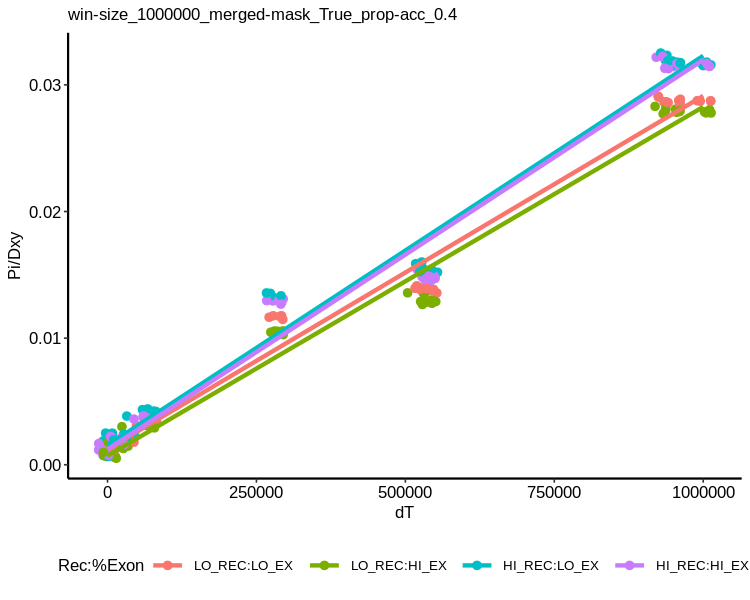

In [24]:
options(repr.plot.width=5, repr.plot.height=4)
pidxy[!is.na(pidxy$mean_rec),] %>%
    group_by(spp1, spp2, combo, stat, drec,dex, dt) %>%
    summarize(meanval=mean(value)) %>%
    ggplot(aes(x=dt, y=meanval, col=drec:dex)) + 
    geom_jitter(width=15000, height=0.0002, ) +
    #geom_pointrange(stat = "summary",
    #                fun.min = function(z) { mean(z) - sd(z) },
    #                fun.max = function(z) { mean(z) + sd(z) },
    #                fun = mean) +
    geom_smooth(aes(x=dt, y=meanval, col=drec:dex), method="lm", se=FALSE) +
    labs(y="Pi/Dxy", x="dT", col="Rec:%Exon", subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pidxy-change-dt_",filemeta$desc,".pdf"), width = 4, height = 3.5, units = "in")

In [25]:
widepidxy = pidxy %>%
    pivot_wider(id_cols = c("chr", "start", "end"), names_from=c("stat","combo"), values_from = value)

cormat = cor(widepidxy%>%dplyr::select(-c("chr", "start", "end")), method="spearman")
cormat[upper.tri(cormat)] <- NA

longcor = melt(cormat)
colnames(longcor) = c("stat_combo1", "stat_combo2", "value")
longcor = longcor[!is.na(longcor$value),]
tmp = unique(pidxy[,c("spp1", "spp2","stat","combo","mrca")])
tmp$sc = paste(tmp$stat, tmp$combo, sep="_")

longcor = left_join(longcor, tmp[,c("mrca","stat", "sc", "spp1", "spp2")], by=c("stat_combo1"="sc"))

Warning message in melt(cormat):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(cormat). In the next version, this warning will become an error."


In [26]:
colnames(longcor) = c("stat_combo1", "stat_combo2", "value", "mrca1", "stat1", "spp1_1", "spp2_1")

In [27]:
longcor = left_join(longcor, tmp[,c("mrca", "stat","sc", "spp1", "spp2")], by=c("stat_combo2"="sc"))

In [28]:
colnames(longcor)[8] = "mrca2"
colnames(longcor)[9] = "stat2"
colnames(longcor)[10] = "spp1_2"
colnames(longcor)[11] = "spp2_2"

In [29]:
longcor$granmrca = apply(longcor, 1, function(x) mrca_mat[x[4],x[8]])
longcor$dt = apply(longcor, 1, function(x) dist_mat[x[4],x[8]])
longcor$statcombo=apply(longcor, 1, function(x) paste(sort(c(x[5], x[9])), collapse="_"))
longcor = longcor[longcor$value !=1.0,] 

In [30]:
longcor$p1 = apply(longcor,1,function(x) sapply(nodepath(tree, label_to_id(x[6], treetbl), label_to_id(x[7], treetbl)), id_to_label, treetbl=treetbl))
longcor[longcor$stat1=="dxy",]$p1 = apply(longcor[longcor$stat1=="dxy",],1, function(x) setdiff(x[15][[1]], x[4]))

In [31]:
longcor$p2 = apply(longcor,1,function(x) sapply(nodepath(tree, label_to_id(x[10], treetbl), label_to_id(x[11], treetbl)), id_to_label, treetbl=treetbl))
longcor[longcor$stat2=="dxy",]$p2 = apply(longcor[longcor$stat2=="dxy",],1, function(x) setdiff(x[16][[1]], x[8]))

In [32]:
longcor$shared_p = apply(longcor, 1, function(x) intersect(x[15][[1]],x[16][[1]]))

In [33]:
longcor$shared  = apply(longcor, 1, function(x) sum(unlist(sapply(x[17][[1]], function(y) edges[edges$edge==y]$gens))))
longcor$denom_px  = apply(longcor, 1, function(x) sum(unlist(sapply(x[15][[1]], function(y) edges[edges$edge==y]$gens))))
longcor$denom_py  = apply(longcor, 1, function(x) sum(unlist(sapply(x[16][[1]], function(y) edges[edges$edge==y]$gens))))

In [34]:
longcor$px = longcor$shared / longcor$denom_px
longcor$py = longcor$shared / longcor$denom_py

In [35]:
longcor$sqsqpxpy = (longcor$px * longcor$py) ^ (1/4)

In [36]:
ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
ne_combo = paste0("pi_",ne_spp)
longcor$lowne=apply(longcor, 1, function(x) any(ne_combo %in% x[1])) | apply(longcor, 1, function(x) any(ne_combo %in% x[2]))

In [37]:
longcor$num_spp = apply(longcor, 1, function(x) length(unique(c(strsplit(str_remove(x[1], "dxy_|pi_"), " ")[[1]], strsplit(str_remove(x[2], "dxy_|pi_"), " ")[[1]]))))

In [38]:
head(longcor[longcor$spp1_1=="central-chimp" & longcor$spp2_1=="humans" & longcor$spp1_2=="central-chimp",])

stat_combo1              stat_combo2                       value    
33   dxy_central-chimp humans pi_central-chimp                  0.8261949
342  dxy_central-chimp humans dxy_central-chimp western-gorilla 0.9196501
777  dxy_central-chimp humans dxy_central-chimp eastern-chimp   0.8332670
923  dxy_central-chimp humans dxy_central-chimp eastern-gorilla 0.9207857
1083 dxy_central-chimp humans dxy_central-chimp nigerian-chimp  0.8315889
     mrca1     stat1 spp1_1        spp2_1 mrca2           stat2 spp1_2       
33   human-pan dxy   central-chimp humans central-chimp   pi    central-chimp
342  human-pan dxy   central-chimp humans african-apes    dxy   central-chimp
777  human-pan dxy   central-chimp humans eastern-central dxy   central-chimp
923  human-pan dxy   central-chimp humans african-apes    dxy   central-chimp
1083 human-pan dxy   central-chimp humans chimps          dxy   central-chimp
     <U+22EF>  
33   <U+22EF>
342  <U+22EF>
777  <U+22EF>
923  <U+22EF>
1083 <U+22EF>
     p2                                                                                                                   
33   central-chimp                                                                                                        
342  central-chimp  , eastern-central, chimps         , pan            , human-pan      , gorilla        , western-gorilla
777  central-chimp, eastern-chimp                                                                                         
923  central-chimp  , eastern-central, chimps         , pan            , human-pan      , gorilla        , eastern-gorilla
1083 central-chimp   , eastern-central , nigerian-western, nigerian-chimp                                                 
     shared_p                                                           shared
33   central-chimp                                                        7000
342  central-chimp  , eastern-central, chimps         , pan             150600
777  central-chimp                                                        7000
923  central-chimp  , eastern-central, chimps         , pan             150600
1083 central-chimp  , eastern-central                                    17120
     denom_px denom_py px         py        sqsqpxpy  lowne num_spp
33   280428     7000   0.02496184 1.0000000 0.3974836 FALSE 2      
342  280428   539037   0.53703624 0.2793871 0.6223755 FALSE 3      
777  280428    14000   0.02496184 0.5000000 0.3342425 FALSE 3      
923  280428   539037   0.53703624 0.2793871 0.6223755 FALSE 3      
1083 280428    34240   0.06104954 0.5000000 0.4179873 FALSE 3

In [39]:
longcor$has_shared = longcor$shared>1e-16

In [40]:
# options(repr.plot.width=5, repr.plot.height=4)
statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
lownelabs = c(`TRUE`="Yes", `False`="No")
p_dt = ggplot(longcor[longcor$has_shared == FALSE,], aes(y=value, x=dt, label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
    geom_point() +
    scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
    scale_x_continuous(labels = label_number(scale = 1e-3)) +
    scale_color_viridis_d(direction=-1, end=0.7) +
    facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
    labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(pi*" in low "*N[e]*" species?"), col="Number of species involved\nin the comparison") +
    ylim(0,1) +
    guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top"))

p_dt
saveRDS(longcor, file = paste0(outpath,"long-cor_",filemeta$desc,".rds"))
ggsave(filename=paste0(outpath, figpath,"cor-pidxy-dT_",filemeta$desc,".pdf"), width = 6.5, height = 3.5, units = "in")

In [41]:
# options(repr.plot.width=5, repr.plot.height=4)
statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
lownelabs = c(`TRUE`="Yes", `False`="No")
p_bo = ggplot(longcor[longcor$has_shared == TRUE,], aes(y=value, x=sqsqpxpy, label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
    geom_point() +
    scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
    scale_x_continuous(labels = label_number(scale = 1e-3)) +
    scale_color_viridis_d(direction=-1, end=0.7) +
    facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
    labs(x=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), y="Correlation between landscapes", shape=bquote(pi*" in low "*N[e]*" species?"), col="Number of species involved\nin the comparison") +
    ylim(0,1) +
    guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top"))

p_bo
ggsave(filename=paste0(outpath, figpath,"cor-pidxy-branchoverlap_",filemeta$desc,".pdf"), width = 6.5, height = 3.5, units = "in")

In [ ]:
m1 = lm(value~1, data=longcor[longcor$statcombo=="dxy_dxy",])
m2 = lm(value~dt, data=longcor[longcor$statcombo=="dxy_dxy",])
m3 = lm(value~sqsqpxpy, data=longcor[longcor$statcombo=="dxy_dxy",])
m4 = lm(value~dt+sqsqpxpy, data=longcor[longcor$statcombo=="dxy_dxy",])
AIC(m1,m2,m3,m4)

In [ ]:
write.table(subset(longcor, select=-c(p1,p2, shared_p)), paste0(outpath,"cor-pidxy-pidxy_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

In [ ]:
pp = ggplotly(p_dt)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-pidxy-dT_",filemeta$desc,".html"))

In [ ]:
pp = ggplotly(p_bo)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-pidxy-branchoverlap_",filemeta$desc,".html"))

In [ ]:
pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value) & pidxy$chr=="chr22",]

In [ ]:
options(repr.plot.width=50, repr.plot.height=3)

# corr exon and recombination rate
pidxy$chr = factor(pidxy$chr, levels=paste0("chr", 1:22))
cor_rec_ex = with(pidxy[pidxy$combo=="humans" & pidxy$stat=="pi",],cor.test(mean_rec,ex_overlap, use="complete.obs"))

coly1 = "#8a501a"
coly2 = "#7a387c"
p_rec_ex = ggplot(data=pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value),], aes(x=start)) + 
                geom_line(aes(y=mean_rec), col=coly1) + geom_line( aes(y=ex_overlap / 3), col=coly2) + 
                geom_point(aes(y=mean_rec), col=coly1, size=0.5) + geom_point( aes(y=ex_overlap / 3), col=coly2, size=0.5) + 
                facet_grid(.~chr, scales = "free_x", space="free_x") +
                stat_cor(aes(x=mean_rec, y=ex_overlap, label = ..r.label..), method="spearman", label.y=6.5, label.x=3e7) +
                scale_y_continuous(name = "Rec rate", sec.axis = sec_axis(~.*2, name="% Exon")) + 
                theme(axis.title.y = element_text(color = coly1), axis.title.y.right = element_text(color = coly2))  + 
                theme(legend.margin=margin(t=0, r=0, b=0, l=-1, unit="cm"))
p_rec_ex


In [ ]:
options(repr.plot.width=50, repr.plot.height=10)

col10palette = c("#cb5e95", "#9bd345", "#9242c5", "#7ecf93", "#665ea9", "#cba657", "#523240", "#c3533b", "#99afc0", "#53673c")
col9palette = c("#7dcd5b","#904cc2","#cbb354","#4b2f51","#8bc6af","#c65381","#575c3a","#c2593b","#9898c4")
p_land = ggplot(data = pidxy, aes(x=start, y=value, group=combo)) +
            geom_line(aes(col=mrca)) +
            facet_grid(stat~chr, scales="free", space="free_x") +
            scale_colour_manual(values=c(col10palette,col9palette)) +
            labs(y="Diversity", x="Window", col="Species") +
            theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"))
p_land

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
statlabs = c(`dxy`="d[XY]", `pi`="pi")
spp_subset=c("humans", "bonobo", "bornean-orangutan", "western-gorilla", "central-chimp")
col5pal = c("#ab62c0","#6ca659","#ca556a","#648ace","#c2843c")
col4pal = c("#b98d3e","#9970c1","#64a860","#cc545e")
subpidxy = pidxy[pidxy$chr=="chr12" & pidxy$spp1 %in% spp_subset & pidxy$spp2 %in% spp_subset,]
subpidxy = subpidxy %>%
  mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
subpidxy$label[duplicated(subpidxy$label)] = NA_character_

In [ ]:
p_land_chr12 = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
            geom_line(aes(col=mrca)) +
            facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed)) +
            scale_colour_manual(values=c(col5pal,col4pal)) +
            labs(y="Value", x="Window", col="Species") +
            theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
            guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
            geom_text_repel(aes(label = label, col=mrca),
                  nudge_x = 1,
                  na.rm = TRUE, force_pull=3.2, xlim=c(1.28e8,NA), size=2) +
            xlim(0, 1.58e8) + guides(color=FALSE)
p_land_chr12

ggsave(filename=paste0(outpath, figpath,"subset-chr12-landscapes_",filemeta$desc,".pdf"),
       width = 6.5, height = 2.1, units = "in", scale=1, limitsize=FALSE)


In [ ]:
(p_land / p_rec_ex) + plot_annotation(title=filemeta$spaced_desc) + plot_layout(heights = c(3, 1))
ggsave(filename=paste0(outpath, figpath,"all-landscapes_",filemeta$desc,".pdf"), width = 200*22, height = 420, units = "mm", limitsize=FALSE)

In [ ]:
hum12 = pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value) & pidxy$chr=="chr22",]
head(hum12)

In [ ]:
#hum12 = hum12  %>% complete(start=full_seq(start, filemeta$win_size))

In [ ]:
#acf(hum12$value, na.action = na.pass)

In [ ]:
#pacf(hum12$value, na.action = na.pass)

In [ ]:
?ts

In [ ]:
x = data.frame(x=c(0), y=c(1,2,4,8), z=c("chr1", "chr2"))

In [ ]:
x

In [ ]:
x%>%group_by(z) %>% complete(y=full_seq(y, 1))

# SEE FROM HERE ON

In [ ]:
# getting internal and external branches
external_branches = tree$tip.label
internal_branches = setdiff(tree$node.label, c(tree$tip.label, "great-apes"))

In [ ]:
unique(as.character(pidxy$chr))[1]

In [ ]:
all_sols = list()
for (ch in unique(as.character(pidxy$chr))) {
    # figuring out new variables with independent components of the branches in the tree
    new_vars = c(paste("pi",external_branches, sep="_"), paste("N", c(internal_branches, external_branches), sep="_"))
    new_vars

    # isolating one window from one chromosome
    chr1 = pidxy[pidxy$chr==ch,]
    chr1 = data.frame(chr1)
    chr1 %>% mutate(across(where(is.factor), as.character)) -> chr1

    # long to wide, widening over windows
    chr1l = chr1 %>% pivot_wider(id_cols=c("spp1","spp2","combo","mrca","ancestral_coding","N","stat","chr"), 
                                 names_from=c("start", "end"), 
                                 values_from = "value")

    # getting the matrix with coefficients relating old variables (pi and dxys) to the new variables
    M=t(apply(chr1l, 1, get_mrow, cols=new_vars, tree=tree, treetbl=treetbl))

    # note we cannot distinguishe the two Ns branching off the root (orangutans and african-apes)
    # and indeed, the rank of our matrix is 27 (and not 28)
    ncol(M)
    qr(M)$rank
    # collapsing the two branches coming from the root - we can't distinguish them
    i_orangs = which(new_vars=="N_orangutans")
    new_vars = new_vars[new_vars!="N_orangutans"]
    new_vars[new_vars=="N_african-apes"] = "N_african-apes-orangutans"
    M=M[,-i_orangs]

    # solving the linear system to get new variables
    sol = ginv(M) %*% as.matrix(chr1l[,9:ncol(chr1l)])

    options(repr.plot.width=4, repr.plot.height=4)
    # making sure we can go back to original variables
    #plot((M %*% sol), as.matrix(chr1l[,9:ncol(chr1l)]))
    all_sols[[ch]] = cbind(t(sol), ch, colnames(sol))
    colnames(all_sols[[ch]]) = c(new_vars, "chr", "startend")
}

In [ ]:
new_vars

In [ ]:
vec = round(ginv(M)[new_vars=="N_humans"]*40, digits=2)

In [ ]:
vnames = apply(chr1l,1, function(x) paste(x[1], x[2]))

In [ ]:
cbind(vec, vnames)

In [ ]:
pin = data.frame(do.call(rbind, all_sols))
rownames(pin) = NULL

In [ ]:
stopifnot(nrow(pin) == nrow(unique(pidxy[,c("chr", "start", "end")])))

In [ ]:
numcols = setdiff(colnames(pin), c("chr", "startend"))
pin[numcols] = sapply(pin[numcols], as.numeric)

In [ ]:
pin[c("start", "end")] = t(sapply(str_split(pin$startend, "_"), as.numeric))

In [ ]:
head(pin)

In [ ]:
# joining with rec map
pin = as.data.table(genome_left_join(pin, rec_map, by = c("chr","start", "end"), minoverlap=2)) # minoverlap bc end is not inclusive
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin=pin[, .(mean_rec = weighted.mean(mean_rate, percent)), by=setdiff(colnames(pin), c("rate", "start.y", "end.y", "chr", "percent", "mean_rate"))]
setnames(pin, c("chr.x","start.x", "end.x"), c("chr","start","end"))
pin[,c("chr.y") := NULL]

In [ ]:
# joining with exons
pin = as.data.table(genome_left_join(pin, exons, by = c("chr", "start", "end"), minoverlap=2))
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin[is.na(pin$percent)]$percent=0
pin=pin[, .(ex_overlap = sum(percent)), by=setdiff(colnames(pin), c("start.y", "chr", "end.y", "percent"))]
setnames(pin, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pin[, ex_overlap := 100*ex_overlap]
pin[,c("chr.y") := NULL]
pin[is.na(pin$ex_overlap), ]$ex_overlap = 0

In [ ]:
# joining with phastcons
pin = as.data.table(genome_left_join(pin, phastcons, by = c("chr", "start", "end"), minoverlap=2))
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin[is.na(pin$percent)]$percent=0
pin=pin[, .(pcons_overlap = sum(percent)), by=setdiff(colnames(pin), c("start.y", "chr", "end.y", "percent"))]
setnames(pin, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pin[, pcons_overlap := 100*pcons_overlap]
pin[,c("chr.y") := NULL]

In [ ]:
# correlations between rec,ex and pcons, and pidxy
options(warn=-1)
rec_percentile=0.7
pin$high_rec = pin$mean_rec > quantile(pin$mean_rec, rec_percentile, na.rm = T)
pin[is.na(pin$high_rec),]$high_rec = FALSE
recbin_labels = c("TRUE" = "High recombination (top 10%)",
                 "FALSE" = "Low recombination (bottom 90%)")
pinw = pin

In [ ]:
pin = pin %>%
    pivot_longer(cols = starts_with("pi") | starts_with("N")) %>%
    separate(name,  c("stat", "branch"), "_")

In [ ]:
head(pin)

In [ ]:
pin$stat = factor(pin$stat, levels=c("pi", "N"))

In [ ]:
pin$branch = str_replace(pin$branch, pattern = "\\.", replace="-")

In [ ]:
new_edge = t(data.frame(c("african-apes-orangutans", "great-apes", 22,
                          apply(edges[edges$edge %in% c("african-apes","orangutans"), c("N")],2,mean),
                          apply(edges[edges$edge %in% c("african-apes","orangutans"), c("gens", "edge_age_kya")],2,sum))))
pin = dplyr::left_join(pin, 
                       rbind(edges[,c("edge", "parent", "ancestral_coding", "N", "gens", "edge_age_kya")],
                             new_edge,
                             use.names = FALSE),
                       by=c("branch"="edge"))



In [ ]:
head(pin)

In [ ]:
u = unique(pin[,c("branch", "ancestral_coding", "gens")])
u$ancestral_coding = as.numeric(u$ancestral_coding)

In [ ]:
pin$branch = factor(pin$branch, levels = u$branch[order(u$ancestral_coding)])

In [ ]:
# scatter plots of relationship between pidxy and annotations for each species-pair
options(repr.plot.width=14, repr.plot.height=14)

ggplot(data=pin, aes(y=value, x=ex_overlap, col=mean_rec)) +
    geom_point(size=1) +
        facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) +
        labs(y="Pi/N", x="% Exon", col="Rec rate", subtitle=filemeta$desc) +
        scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"exon-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

ggplot(data=pin, aes(y=value, x=pcons_overlap, col=mean_rec)) +
    geom_point(size=1) +
    facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) +
    labs(y="Pi/N", x="% PhastCons", col="Rec rate", subtitle=filemeta$desc) + 
    scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"pcons-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

ggplot(data=pin, aes(y=value, x=mean_rec, col=ex_overlap)) + 
    geom_point(size=1) + 
    facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) + 
    labs(y="Pi/Dxy", x="Rec rate", col="% Exon", subtitle=filemeta$desc) + 
scale_colour_viridis_c(direction=-1)
ggsave(filename=paste0(outpath, figpath,"rec-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

In [ ]:
cormat = cor(pinw%>%dplyr::select(-c("chr", "start", "end", "startend", "mean_rec", "ex_overlap", "pcons_overlap", "high_rec")), method="spearman")
#cormat[upper.tri(cormat)] <- NA

In [ ]:
cormat

In [ ]:
lcormat = melt(cormat)
lcormat = lcormat[!is.na(lcormat$value),]

In [ ]:
lcormat$Var1 = str_replace(lcormat$Var1, pattern = "\\.", replace="-")

In [ ]:
lcormat$Var2 = str_replace(lcormat$Var2, pattern = "\\.", replace="-")

In [ ]:
lcormat = lcormat %>% separate(Var1, c("stat1", "spp1"), "_") %>% separate(Var2, c("stat2", "spp2"), "_")

In [ ]:
utree = unroot(tree)
utreetbl = as_tibble(utree)
udist_mat = dist.nodes(utree)

In [ ]:
utree$node.label

In [ ]:
str(utree)

In [ ]:
udistmat = dist.nodes(utree)

In [ ]:
strsplit(lcormat[11,]$spp1, "\\.")

In [ ]:
dist_between_branches = function(spp1, spp2, udistmat, utreetbl) {
    s1 = spp1
    s2 = spp1
    s3 = spp2
    if (spp1 == "african-apes.orangutans") {
        s1 = "african-apes"
        s2 = "orangutans"
        s3 = spp2
    } else if(spp2 == "african-apes.orangutans") {
        s1 = "african-apes"
        s2 = "orangutans"
        s3 = spp1
    }
    d1 = udistmat[label_to_id(s1, utreetbl),label_to_id(s3, utreetbl)]
    d2 = udistmat[label_to_id(s2, utreetbl),label_to_id(s3, utreetbl)]
    return(min(c(d1,d2)))
}

In [ ]:
head(lcormat)

In [ ]:
lcormat$dt = apply(lcormat,1, function(x) dist_between_branches(x[2], x[4], udistmat, utreetbl))
lcormat$statcombo = paste(lcormat$stat1, lcormat$stat2, sep="_")
lcormat$statcombo1 = paste(lcormat$stat1, lcormat$spp1, sep="_")
lcormat$statcombo2 = paste(lcormat$stat2, lcormat$spp2, sep="_")


In [ ]:
options(repr.plot.width=5, repr.plot.height=4)
p = ggplot(lcormat, aes(y=value, x=dt, col=statcombo, label=statcombo1, label2=statcombo2)) + geom_point() +
    labs(x="dT", y="Correlation (for all pi/N combos)", col="Stats")
pp=ggplotly(p)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-piN-dT_",filemeta$desc,".html"))
pp
#saveRDS(longcor, file = paste0(outpath,"long-cor_",desc,".rds"))
#ggsave(filename=paste0(outpath,"cor-pidxy-exon-dT_",desc,".pdf"), width = 250, height = 200, units = "mm")

In [ ]:
head(lcormat)

In [ ]:
options(repr.plot.width=15, repr.plot.height=14)
col17pal = c("#7183ca",
"#4fb850",
"#c05ac5",
"#8eb239",
"#7362cf",
"#bdad4d",
"#d3478a",
"#62bd8e",
"#c64251",
"#45b0cf",
"#d3542d",
"#3f7f46",
"#b16aa1",
"#757831",
"#db7d81",
"#dc9747",
"#a26335")
ggplot(lcormat, aes(y=value, x=dt, col=spp1, shape=statcombo)) + geom_point(size=2) +
    labs(x="dT", y="Correlation (for all pi/N combos)", col="Stats")+ 
    facet_wrap(vars(statcombo2))+
    scale_fill_manual(values =col17pal) +
    scale_color_manual(values =col17pal)
ggsave(filename=paste0(outpath, figpath,"pairwisecorrs-piN_",filemeta$desc,".pdf"), width = 600, height = 600, units = "mm")

In [ ]:
lcormat %>%
    group_by(spp1) %>%
    count()

In [ ]:
write.table(pidxy, paste0(outpath,"pidxy-filtered-withmetadata_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(pin, paste0(outpath,"piN-withmetadata_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(lcormat, paste0(outpath,"cor-pin-pin_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)